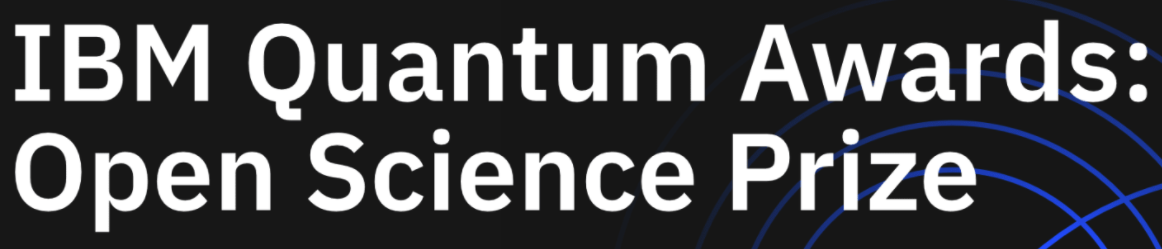

***This Notebook explains we compare the results, as we use the real results that's been generated from IBM casablanca system.***

## Initial - Must run!

running all the releveant packages to make sure everything run smoothly

### The packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -r /content/drive/MyDrive/Shared\ drive/dependencies/requirements.txt --quiet

In [ ]:
! pip install 'qiskit==0.23.0'

Processing /root/.cache/pip/wheels/8f/3a/44/dcb4239f2c3b1990d89c1c931e11d302d8d8a6cd650cb8b79b/qiskit-0.23.0-cp37-none-any.whl
  Using cached https://files.pythonhosted.org/packages/06/c2/baad998e3e462266bc9c10b9ad8fe9e692b39f5774f6c77e484c1dfdc91e/qiskit_ibmq_provider-0.11.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a8/6a/64cac46d5ef10703ee59b07f6de45e124118c763ad5e067b3addcbb867e4/qiskit_terra-0.16.0-cp37-cp37m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/9f/c9/28cbe3ada1f1417fcc02797f51ca33810f8eea9d8537bbca7283bde77888/qiskit_aer-0.7.0-cp37-cp37m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/30/0f/ae104c53cc0cf84680dcc19ea329ab383620dce7a3db5c8ff54063e3fa95/qiskit_aqua-0.8.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a0/7f/ea6794cb029d235317e793483197fb562e0b344a3e4c572f7c033c6635dc/qiskit_ignis-0.5.0-py3-none-any.whl
  Found existing installation: qiskit-

In [ ]:
!pip install pydash

In [ ]:
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for noisy simulation
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.utils import insert_noise

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

# Other imports
import numpy as np

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Me importing a NN package - TensorFlow 2 and another important classes for the NN i'll be doing
import tensorflow
import random
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.python.ops import math_ops
from tqdm import tqdm_notebook
from keras import backend as K
import tensorflow as tf

### IBM account

In [ ]:
# Load IBMQ Account data
from qiskit import IBMQ
#IBMQ.delete_account()
IBMQ.save_account('6b667b93838abce50a0b809f6aa90c5952e88eb0631098a08695a4e7ce8bc726fe3b0b5cfe857730c9739fcedb4f982b24d513474ee61eab931b16b7915f59a8')
IBMQ.load_account()

# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-research', group='bar-ilan-uni-1', project='main')
backend = provider.get_backend('ibmq_casablanca')
backend_new = QasmSimulator.from_backend(backend)
properties = backend.properties()

configrc.store_credentials:WARNING:2021-04-09 22:00:11,017: Credentials already present. Set overwrite=True to overwrite.


### function from IBM

In [ ]:
def compute_stabilizer_group(circuit):
    """Compute the stabilizer group for stabilizer circuit."""
    state = qi.Statevector.from_instruction(circuit)
    labels = []
    for i in qi.pauli_basis(state.num_qubits):
        val = round(qi.state_fidelity(i.to_matrix()[0], state, validate=False))
        if val != 0:
            label = i.to_labels()[0]
            if val == 1:
                label = '+' + label
            else:
                label = '-' + label
            labels.append(label)
    return labels

In [ ]:
def stabilizer_coeff_pauli(stabilizer):
    """Return the 1 or -1 coeff and Pauli label."""
    coeff = 1
    pauli = coeff
    if stabilizer[0] == '-':
        coeff = -1
    if stabilizer[0] in ['+', '-']:
        pauli = stabilizer[1:]
    else:
        pauli = stabilizer
    return coeff, pauli

In [ ]:
def stabilizer_measure_circuit(stabilizer, initial_circuit=None):
    """Return a stabilizer measurement circuits.
    
    Args:
        stabilizer (str): a stabilizer string
        initial_circuit (QuantumCircuit): Optional, the initial circuit.
    
    Returns:
        QuantumCircuit: the circuit with stabilizer measurements.
    """
    _, pauli = stabilizer_coeff_pauli(stabilizer)
    if initial_circuit is None:
        circ = QuantumCircuit(len(pauli))
    else:
        circ = initial_circuit.copy()
    for i, s in enumerate(reversed(pauli)):
        if s == 'X':
            circ.h(i)
        if s == 'Y':
            circ.sdg(i)
            circ.h(i)
    circ.measure_all()
    return circ

In [ ]:
def stabilizer_expvals(result, stabilizers, meas_mitigator=None):
    """Compute expectation values from stabilizer measurement results."""

    ### YOUR CODE GOES HERE -- START

    expvals = []
    stddevs = []
    for i, stab in enumerate(stabilizers):
        expval, stddev = mit.expectation_value(
            result.get_counts(i),
            diagonal=stabilizer_measure_diagonal(stab),
            meas_mitigator=meas_mitigator)

        expvals.append(expval)
        stddevs.append(stddev)
    return np.array(expvals), np.array(stddevs)

In [ ]:
def stabilizer_measure_diagonal(stabilizer):
    """Return the diagonal vector for a stabilizer measurement.
    
    Args:
        stabilizer (str): a stabilizer string
    
    Returns:
        np.ndarray: the diagonal for measurement in the stabilizer basis.
    """
    coeff, pauli = stabilizer_coeff_pauli(stabilizer)
    diag = np.array([1])
    for s in reversed(pauli):
        if s == 'I':
            tmp = np.array([1, 1])
        else:
            tmp = np.array([1, -1])
        diag = np.kron(tmp, diag)
    return coeff * diag

In [ ]:
def stabilizer_fidelity(expvals, stddevs=None):
    """Compute stabilizer state fidelity from stabilizer expvals."""
    mean = np.mean(expvals)
    if stddevs is None:
        return mean
    stddev = np.sqrt(np.sum(stddevs ** 2))
    return mean, stddev

### Functions I made for the NN data, and are necessary here as well

In [ ]:
def stabilizer_expvals_without_counts(result, stabilizers):
    """Compute expectation values from stabilizer measurement results."""

    ### YOUR CODE GOES HERE -- START

    expvals = []
    stddevs = []
    for i, stab in enumerate(stabilizers):
        expval, stddev = mit.expectation_value(
            result[i],
            diagonal=stabilizer_measure_diagonal(stab))

        expvals.append(expval)
        stddevs.append(stddev)

    return np.array(expvals), np.array(stddevs)

    ### YOUR CODE GOES HERE -- END

In [ ]:
def dict_to_hist(reps, result_backend):
  '''
  the function takes the measurement Results of IBM, and returns the full
  histogram of the data for NN 
  '''
  template_labels = [bin(x)[2:].rjust(num_qubits, '0') for x in range(2**num_qubits)]
  template = {el:0 for el in template_labels}
  expval = []

  for i in range(reps):
      temp_list = []
      for j in range(len(result_backend[i].get_counts())):
          template = {el:0 for el in template_labels}
          for k in result_backend[i].get_counts(j).keys():
              template[k] = result_backend[i].get_counts(j)[k]
          temp_list.append(template)
      expval.append(temp_list)
  
  return expval

In [ ]:
def hist_for_NN(expval,reps,labels):
    x_full = []
    for i in range(reps):
      x = []
      for j in range(len(labels)):
          x.append(np.array(list(expval[i][j].values()))/np.array(list(expval[i][j].values())).sum())
      x_full.append(x)
    return x_full

In [ ]:
def hist_for_NN_Data(expval,reps,labels):
    x = []
    for i in range(reps):
      for j in range(len(labels)):
          x.append(np.array(list(expval[i][j].values()))/np.array(list(expval[i][j].values())).sum())
    return x

In [ ]:
def Data_For_NN(adjmat ,reps , num_qubits, shots, labels):
    '''
    this function generates a new results for the NN model function, and returns it's histograms. 
    '''
    ################################# first let's generate a different data- by using the same method as IBM did 
    

    # the graph state can be created using Qiskit's circuit library
    state_circuit = create_graph_state()
    state_circuit.draw()
    
    stabilizers = compute_stabilizer_group(state_circuit)
    
    stabilizer_circuits = [stabilizer_measure_circuit(stab, state_circuit)
                       for stab in stabilizers]
       
    meas_cal_circuits, metadata = mit.expval_meas_mitigator_circuits(num_qubits, method='CTMP', labels=labels)

    il = [0,1,2,3,4,5,6]

    all_jobs = []
    all_jobs_mit = []

    for ii in tqdm_notebook(range(reps)):
        # Run QPT on backend
        job_backend = execute(stabilizer_circuits, backend_new, shots=shots, initial_layout=il)
        job_mit_backend = execute(meas_cal_circuits, backend_new, shots=shots, initial_layout=il)
        all_jobs.append(job_backend)
        all_jobs_mit.append(job_mit_backend)
    
    result_backend = []
    result_mit_backend = []
    
    for job in all_jobs:
        # Retrieve results (this may take a while depending on the queue)
        result_backend.append(job.result())
    
    for job in all_jobs_mit:
        result_mit_backend.append(job.result())  

    # the correct result from the stabilizer
    
    ideal_simulator = QasmSimulator()

    all_jobs_correct = []
    for ii in range(reps):
            # Run QPT on backend
            job_backend_correct = execute(meas_cal_circuits, ideal_simulator, shots=shots, initial_layout=il)
            all_jobs_correct.append(job_backend_correct)

    result_backend_correct = []
    
    for job in all_jobs_correct:
        # Retrieve results (this may take a while depending on the queue)
        result_backend_correct.append(job.result())     
        
    # make a template so all the data will be the same size for NN

    expval_correct = dict_to_hist(reps, result_backend_correct)
    expval = dict_to_hist(reps, result_backend)
    expval_mit = dict_to_hist(reps, result_mit_backend)

        ###################################################################
    return expval, expval_mit, expval_correct, result_backend, result_mit_backend

In [ ]:
def create_graph_state():
    
    ### YOUR CODE GOES HERE -- START
    
    graph_state_circuit = circuit_library.GraphState(adjmat)
    
    ### YOUR CODE GOES HERE -- END
    
    return graph_state_circuit

### Constants for the NN

In [ ]:
adjmat = [
    [0, 1, 0, 0, 0, 0, 0], 
    [1, 0, 1, 1, 0, 0, 0], 
    [0, 1, 0, 0, 0, 0, 0], 
    [0, 1, 0, 0, 0, 1, 0], 
    [0, 0, 0, 0, 0, 1, 0], 
    [0, 0, 0, 1, 1, 0, 1], 
    [0, 0, 0, 0, 0, 1, 0]]

In [ ]:
## Compute the stabilizers for this graph state
state_circuit = create_graph_state()
#generators = qi.Clifford(state_circuit).stabilizer.pauli.to_labels()
stabilizers = compute_stabilizer_group(state_circuit)

In [ ]:
reps = 16

In [ ]:
num_qubits = 7

In [ ]:
shots = 8192

In [ ]:
labels = ['0000000', '0000011', '0000101', 
      '0001001', '0001010', '0001100', 
      '0010001', '0010010', '0010100', '0011000', 
      '0100001', '0100010', '0100100', '0101000', '0110000', 
      '1000001', '1000010', '1000100', '1001000', '1010000', '1100000', 
      '1111111']

In [ ]:
meas_cal_circuits, metadata  = mit.expval_meas_mitigator_circuits(num_qubits, method='CTMP', labels=labels)

# Uploading The saved Data

## uploading the NN models

In [ ]:
model_first = keras.models.load_model('/content/drive/MyDrive/Shared drive/NN model of IBM prize')
model_second = keras.models.load_model('/content/drive/MyDrive/Shared drive/NN model of IBM prize with Emmanuelles assumptions')

## uploading of the real results

In [ ]:
result_backend = np.load('/content/drive/MyDrive/Shared drive/real IBM casablanca results/result_backend.npy', allow_pickle=True)
result_mit_backend = np.load('/content/drive/MyDrive/Shared drive/real IBM casablanca results/result_mit_backend.npy', allow_pickle=True)

#The Comparison Between 2 Models With the real system

here, we'll show you the real fidelity of the system casablanca itself - and the results of the whole models.


*the real measurements id will be shown at the end of this section*


i saved the results and loaded in a different notebooks in order to calculate the fidelity.

In [ ]:
expval = dict_to_hist(reps, result_backend)

after the i wrote a code to compare the result - and even made a plot bar

### for the first model

### With Treshold

In [ ]:
template_labels = [bin(x)[2:].rjust(num_qubits, '0') for x in range(2**num_qubits)]

test_list = hist_for_NN(expval,reps,template_labels)

F_mit_NN = []
for k in range(reps):
  F_mit_NN.append(model_first.predict(np.array(test_list)[k])*shots)
for k in range(reps):
  F_mit_NN[k][F_mit_NN[k] < 0.01*shots] = 0
temp_list_full = []

F_nomit_backend = []
F_mit_backend = []

temp_list = []

for k in range(reps):
  temp_list_l = []
  for i in range(2**num_qubits):
    template = {el:0 for el in template_labels}
    for j in range(F_mit_NN[k][i].shape[0]):
        template[template_labels[j]] = F_mit_NN[k][i][j] #
    temp_list_l.append(template)    
  temp_list.append(temp_list_l) 

F_mit_backend_NN_threshhold = []

for ii in range(reps):
    F_mit_NN_exp_val, F_mit_NN_std_val = stabilizer_expvals_without_counts(temp_list[ii], stabilizers)
    F_mit_backend_NN_threshhold.append(stabilizer_fidelity(F_mit_NN_exp_val, F_mit_NN_std_val)[0])

for ii in range(reps):
    # Unmitigated Expectation Values
    expvals_nomit_b, stddevs_nomit_b = stabilizer_expvals(
        result_backend[ii], stabilizers)
    F_nomit_backend.append(stabilizer_fidelity(expvals_nomit_b, stddevs_nomit_b)[0])
    # Fit measurement error mitigators
    mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit_backend[ii], metadata).fit()
    # Measurement error mitigated expectation values
    expvals_mit_b, stddevs_mit_b = stabilizer_expvals(
        result_backend[ii], stabilizers, meas_mitigator=mitigator_backend)
    F_mit_backend.append(stabilizer_fidelity(expvals_mit_b, stddevs_mit_b)[0])

print('\nNN fully-C\
onnected error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend_NN_threshhold), np.std(F_mit_backend_NN_threshhold)))

print('\nNo mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_nomit_backend), np.std(F_nomit_backend)))

print('\nCTMP error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend), np.std(F_mit_backend)))



NN fully-Connected error mitigation
F(ibmq_casablanca) = 0.989 ± 0.007

No mitigation
F(ibmq_casablanca) = 0.621 ± 0.023

CTMP error mitigation
F(ibmq_casablanca) = 0.757 ± 0.037


### without Treshold

In [ ]:
template_labels = [bin(x)[2:].rjust(num_qubits, '0') for x in range(2**num_qubits)]

test_list = hist_for_NN(expval,reps,template_labels)

F_mit_NN = []
for k in range(reps):
  F_mit_NN.append(model_first.predict(np.array(test_list)[k])*shots)
temp_list_full = []

F_nomit_backend = []
F_mit_backend = []

temp_list = []

for k in range(reps):
  temp_list_l = []
  for i in range(2**num_qubits):
    template = {el:0 for el in template_labels}
    for j in range(F_mit_NN[k][i].shape[0]):
        template[template_labels[j]] = F_mit_NN[k][i][j] #
    temp_list_l.append(template)    
  temp_list.append(temp_list_l) 
   
F_mit_backend_NN = []

for ii in range(reps):
    F_mit_NN_exp_val, F_mit_NN_std_val = stabilizer_expvals_without_counts(temp_list[ii], stabilizers)
    F_mit_backend_NN.append(stabilizer_fidelity(F_mit_NN_exp_val, F_mit_NN_std_val)[0])

for ii in range(reps):
    # Unmitigated Expectation Values
    expvals_nomit_b, stddevs_nomit_b = stabilizer_expvals(
        result_backend[ii], stabilizers)
    F_nomit_backend.append(stabilizer_fidelity(expvals_nomit_b, stddevs_nomit_b)[0])
    # Fit measurement error mitigators
    mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit_backend[ii], metadata).fit()
    # Measurement error mitigated expectation values
    expvals_mit_b, stddevs_mit_b = stabilizer_expvals(
        result_backend[ii], stabilizers, meas_mitigator=mitigator_backend)
    F_mit_backend.append(stabilizer_fidelity(expvals_mit_b, stddevs_mit_b)[0])

print('\nNN fully-C\
onnected error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend_NN), np.std(F_mit_backend_NN)))

print('\nNo mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_nomit_backend), np.std(F_nomit_backend)))

print('\nCTMP error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend), np.std(F_mit_backend)))


Encountered a negative variance in expectation value calculation.(-0.000001). Setting standard deviation of result to 0.
Encountered a negative variance in expectation value calculation.(-0.000001). Setting standard deviation of result to 0.
Encountered a negative variance in expectation value calculation.(-0.000003). Setting standard deviation of result to 0.
Encountered a negative variance in expectation value calculation.(-0.000002). Setting standard deviation of result to 0.
Encountered a negative variance in expectation value calculation.(-0.000000). Setting standard deviation of result to 0.
Encountered a negative variance in expectation value calculation.(-0.000000). Setting standard deviation of result to 0.
Encountered a negative variance in expectation value calculation.(-0.000000). Setting standard deviation of result to 0.
Encountered a negative variance in expectation value calculation.(-0.000001). Setting standard deviation of result to 0.
Encountered a negative variance 


NN fully-Connected error mitigation
F(ibmq_casablanca) = 0.775 ± 0.029

No mitigation
F(ibmq_casablanca) = 0.621 ± 0.023

CTMP error mitigation
F(ibmq_casablanca) = 0.757 ± 0.037


### The graph

<ErrorbarContainer object of 3 artists>

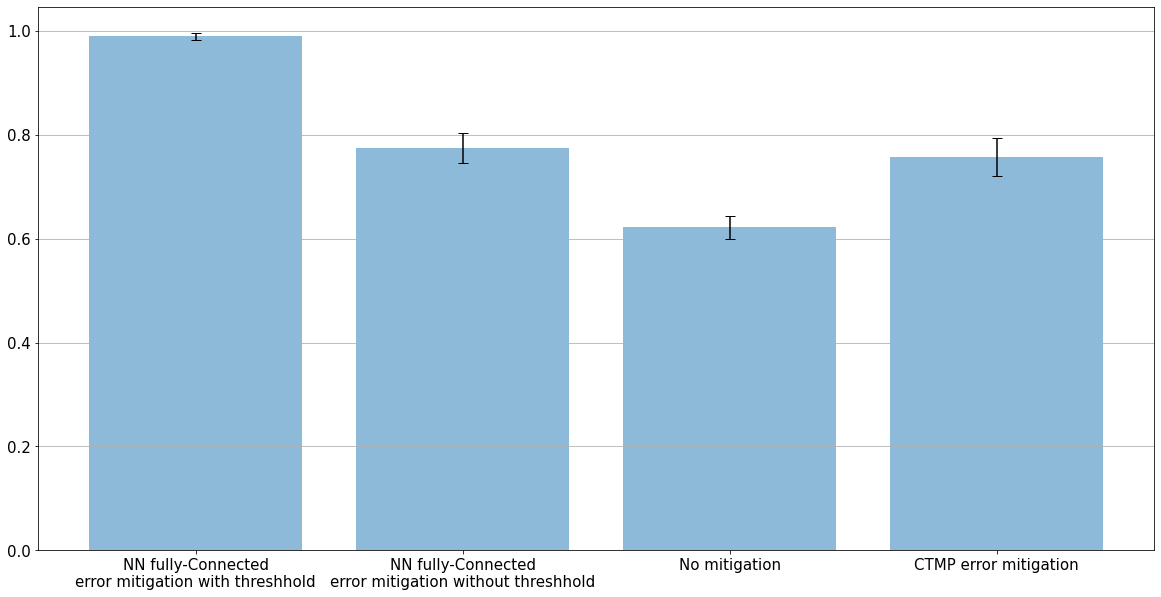

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=[20,10])
plt.grid(axis='y')
plt.bar(["NN fully-Connected\nerror mitigation with threshhold","NN fully-Connected\nerror mitigation without threshhold","No mitigation","CTMP error mitigation"],[np.mean(F_mit_backend_NN_threshhold),np.mean(F_mit_backend_NN),np.mean(F_nomit_backend),np.mean(F_mit_backend)], alpha=0.5)
plt.errorbar(["NN fully-Connected\nerror mitigation with threshhold","NN fully-Connected\nerror mitigation without threshhold","No mitigation","CTMP error mitigation"],[np.mean(F_mit_backend_NN_threshhold),np.mean(F_mit_backend_NN),np.mean(F_nomit_backend),np.mean(F_mit_backend)],yerr=[np.std(F_mit_backend_NN_threshhold),np.std(F_mit_backend_NN),np.std(F_nomit_backend),np.std(F_mit_backend)],fmt='s', color='black', marker='.', markersize=0.1, capsize=5)


### for the second model


### With Threshold

In [ ]:
template_labels = [bin(x)[2:].rjust(num_qubits, '0') for x in range(2**num_qubits)]

test_list = hist_for_NN(expval,reps,template_labels)

F_mit_NN = []
for k in range(reps):
  F_mit_NN.append(model_second.predict(np.array(test_list)[k])*shots)
for k in range(reps):
  F_mit_NN[k][F_mit_NN[k] < 0.01*shots] = 0
temp_list_full = []

F_nomit_backend = []
F_mit_backend = []

temp_list = []

for k in range(reps):
  temp_list_l = []
  for i in range(2**num_qubits):
    template = {el:0 for el in template_labels}
    for j in range(F_mit_NN[k][i].shape[0]):
        template[template_labels[j]] = F_mit_NN[k][i][j] #
    temp_list_l.append(template)    
  temp_list.append(temp_list_l) 

F_mit_backend_NN_threshhold = []

for ii in range(reps):
    F_mit_NN_exp_val, F_mit_NN_std_val = stabilizer_expvals_without_counts(temp_list[ii], stabilizers)
    F_mit_backend_NN_threshhold.append(stabilizer_fidelity(F_mit_NN_exp_val, F_mit_NN_std_val)[0])

for ii in range(reps):
    # Unmitigated Expectation Values
    expvals_nomit_b, stddevs_nomit_b = stabilizer_expvals(
        result_backend[ii], stabilizers)
    F_nomit_backend.append(stabilizer_fidelity(expvals_nomit_b, stddevs_nomit_b)[0])
    # Fit measurement error mitigators
    mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit_backend[ii], metadata).fit()
    # Measurement error mitigated expectation values
    expvals_mit_b, stddevs_mit_b = stabilizer_expvals(
        result_backend[ii], stabilizers, meas_mitigator=mitigator_backend)
    F_mit_backend.append(stabilizer_fidelity(expvals_mit_b, stddevs_mit_b)[0])

print('\nNN fully-C\
onnected error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend_NN_threshhold), np.std(F_mit_backend_NN_threshhold)))

print('\nNo mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_nomit_backend), np.std(F_nomit_backend)))

print('\nCTMP error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend), np.std(F_mit_backend)))



NN fully-Connected error mitigation
F(ibmq_casablanca) = 0.989 ± 0.007

No mitigation
F(ibmq_casablanca) = 0.621 ± 0.023

CTMP error mitigation
F(ibmq_casablanca) = 0.757 ± 0.037


### Without Threshold

In [ ]:
template_labels = [bin(x)[2:].rjust(num_qubits, '0') for x in range(2**num_qubits)]

test_list = hist_for_NN(expval,reps,template_labels)

F_mit_NN = []
for k in range(reps):
  F_mit_NN.append(model_second.predict(np.array(test_list)[k])*shots)
temp_list_full = []

F_nomit_backend = []
F_mit_backend = []

temp_list = []

for k in range(reps):
  temp_list_l = []
  for i in range(2**num_qubits):
    template = {el:0 for el in template_labels}
    for j in range(F_mit_NN[k][i].shape[0]):
        template[template_labels[j]] = F_mit_NN[k][i][j] #
    temp_list_l.append(template)    
  temp_list.append(temp_list_l) 
   
for ii in range(reps):
    F_mit_NN_exp_val, F_mit_NN_std_val = stabilizer_expvals_without_counts(temp_list[ii], stabilizers)
    F_mit_backend_NN.append(stabilizer_fidelity(F_mit_NN_exp_val, F_mit_NN_std_val)[0])

for ii in range(reps):
    # Unmitigated Expectation Values
    expvals_nomit_b, stddevs_nomit_b = stabilizer_expvals(
        result_backend[ii], stabilizers)
    F_nomit_backend.append(stabilizer_fidelity(expvals_nomit_b, stddevs_nomit_b)[0])
    # Fit measurement error mitigators
    mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit_backend[ii], metadata).fit()
    # Measurement error mitigated expectation values
    expvals_mit_b, stddevs_mit_b = stabilizer_expvals(
        result_backend[ii], stabilizers, meas_mitigator=mitigator_backend)
    F_mit_backend.append(stabilizer_fidelity(expvals_mit_b, stddevs_mit_b)[0])

print('\nNN fully-C\
onnected error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend_NN), np.std(F_mit_backend_NN)))

print('\nNo mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_nomit_backend), np.std(F_nomit_backend)))

print('\nCTMP error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend), np.std(F_mit_backend)))


### The graph

<ErrorbarContainer object of 3 artists>

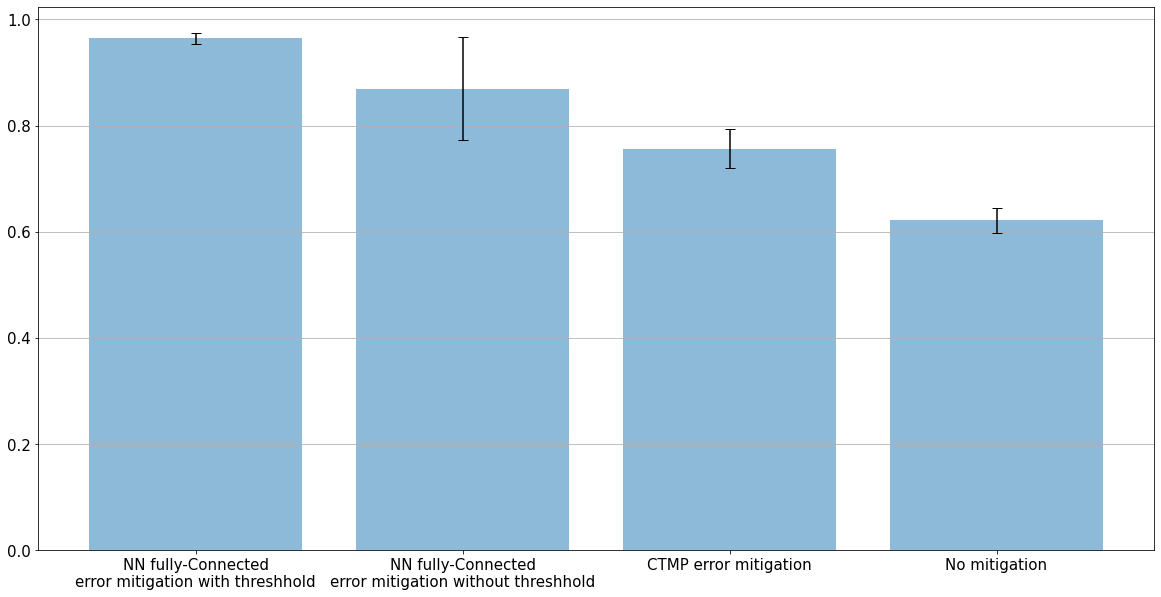

In [40]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=[20,10])
plt.grid(axis='y')
plt.bar(["NN fully-Connected\nerror mitigation with threshhold","NN fully-Connected\nerror mitigation without threshhold","CTMP error mitigation","No mitigation"],[np.mean(F_mit_backend_NN_threshhold),np.mean(F_mit_backend_NN),np.mean(F_mit_backend),np.mean(F_nomit_backend)], alpha=0.5)
plt.errorbar(["NN fully-Connected\nerror mitigation with threshhold","NN fully-Connected\nerror mitigation without threshhold","CTMP error mitigation","No mitigation"],[np.mean(F_mit_backend_NN_threshhold),np.mean(F_mit_backend_NN),np.mean(F_mit_backend),np.mean(F_nomit_backend)],yerr=[np.std(F_mit_backend_NN_threshhold),np.std(F_mit_backend_NN),np.std(F_mit_backend),np.std(F_nomit_backend)],fmt='s', color='black', marker='.', markersize=0.1, capsize=5)


# Here's the job id's

```
Job IDs (1/16): 
 measurement calibration: 603bc5585728cef7502bf4cb
 stabilizer measurements: 603bc553e8504d7d973ec7fa
Job IDs (2/16): 
 measurement calibration: 603bc5688c2165dfd642e018
 stabilizer measurements: 603bc565e8504d95dd3ec7fb
Job IDs (3/16): 
 measurement calibration: 603bc5775728ced3df2bf4ce
 stabilizer measurements: 603bc574742e5379018028e6
Job IDs (4/16): 
 measurement calibration: 603bc58dc6d1d19900f9a6bf
 stabilizer measurements: 603bc587c6d1d13322f9a6be
Job IDs (5/16): 
 measurement calibration: 603bc59f5728ce67622bf4d3
 stabilizer measurements: 603bc5998c2165589d42e01c
Job IDs (6/16): 
 measurement calibration: 603bc5afa6240768bdc8b200
 stabilizer measurements: 603bc5abead6eefc9bedd95d
Job IDs (7/16): 
 measurement calibration: 603bc5c06760ce4e9260d9cb
 stabilizer measurements: 603bc5bc6ebbe1387b71fed5
Job IDs (8/16): 
 measurement calibration: 603bc5d1a624079eb3c8b202
 stabilizer measurements: 603bc5cc8c21654c4b42e01f
Job IDs (9/16): 
 measurement calibration: 603bc5e16ebbe1439d71fed8
 stabilizer measurements: 603bc5ddc6d1d155a1f9a6c2
Job IDs (10/16): 
 measurement calibration: 603bc5f25728ceb1db2bf4d8
 stabilizer measurements: 603bc5ee6ebbe1e7ed71fed9
Job IDs (11/16): 
 measurement calibration: 603bc602fcca6bee794c6e97
 stabilizer measurements: 603bc5fe6760ce036e60d9d0
Job IDs (12/16): 
 measurement calibration: 603bc612fcca6b3ad44c6e98
 stabilizer measurements: 603bc60ec6d1d17715f9a6c4
Job IDs (13/16): 
 measurement calibration: 603bc6228c2165506542e025
 stabilizer measurements: 603bc61efcca6b25154c6e99
Job IDs (14/16): 
 measurement calibration: 603bc636a62407c779c8b208
 stabilizer measurements: 603bc62e8c2165039342e026
Job IDs (15/16): 
 measurement calibration: 603bc64aead6eef302edd969
 stabilizer measurements: 603bc643c6d1d138b5f9a6c7
Job IDs (16/16): 
 measurement calibration: 603bc65da6240722bac8b20a
 stabilizer measurements: 603bc6576ebbe1207171fedd
```

